#### Importación de bibliotecas

In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu 

## Carga de la base de datos

In [2]:
df = pd.read_csv("../Data/tourist_accommodation_clean.csv")
pd.set_option('display.max_columns', None)
df.head()

,apartment_id,name,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,city,insert_date
0,11964,A ROOM WITH A VIEW,45553,Centro,Desconocido,Private room,2,2.0,1.0,2,"TV,Internet,Wifi,Air conditioning,Elevator,Buz...",400.0,3,365,True,7,20,40,130,78,2010-02-01,2017-05-09,970.0,100.0,100.0,100.0,100.0,100.0,100.0,False,75.0,malaga,2018-07-31
1,21853,Bright and airy room,83531,C�rmenes,Latina,Private room,1,1.0,1.0,1,"TV,Internet,Wifi,Air conditioning,Kitchen,Free...",170.0,4,40,True,0,0,0,162,33,2014-10-10,NaN,920.0,90.0,90.0,100.0,100.0,80.0,90.0,False,52.0,madrid,2020-01-10
2,32347,Explore Cultural Sights from a Family-Friendly...,139939,San Vicente,Casco Antiguo,Entire home/apt,4,1.0,2.0,4,"TV,Internet,Wifi,Air conditioning,Wheelchair a...",990.0,2,120,True,26,31,31,270,148,2011-05-01,NaN,980.0,100.0,100.0,100.0,100.0,100.0,100.0,True,142.0,sevilla,2019-07-29
3,35379,Double 02 CasanovaRooms Barcelona,152232,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,2.0,1.0,2,"TV,Internet,Wifi,Kitchen,Breakfast,Elevator,Bu...",400.0,2,730,True,9,23,49,300,292,NaN,2020-04-01,940.0,100.0,90.0,100.0,100.0,100.0,90.0,True,306.0,barcelona,2020-01-10
4,35801,Can Torras Farmhouse Studio Suite,153805,Quart,Desconocido,Private room,5,1.0,2.0,5,"Wifi,Pool,Free parking on premises,Breakfast,P...",900.0,1,180,True,0,19,49,312,36,2011-08-07,2018-08-08,970.0,100.0,100.0,100.0,100.0,100.0,100.0,False,39.0,girona,2019-02-19


In [3]:
registros_totales = len(df)
print(f'Total de registros de la DB: {registros_totales}')

Total de registros de la DB: 10000


##### Análisis estadísticos y outliers


 Distribución Variables Numéricas:

                               Media  Desviación estándar  Mínimo  Q1 (25%)  Mediana  Q3 (75%)   Máximo
accommodates                    4.27                 2.58     1.0       2.0      4.0       6.0     29.0
bathrooms                       1.59                 0.99     0.0       1.0      1.0       2.0     13.0
bedrooms                        1.93                 1.37     0.0       1.0      2.0       3.0     50.0
beds                            4.27                 2.58     1.0       2.0      4.0       6.0     29.0
price                        1017.33               963.37    60.0     450.0    750.0    1200.0  28571.0
minimum_nights                  4.95                17.73     1.0       1.0      2.0       4.0   1125.0
maximum_nights                759.77               498.37     1.0      62.0   1125.0    1125.0   1125.0
availability_30                13.01                11.84     0.0       0.0     11.0      26.0     30.0
availability_60            

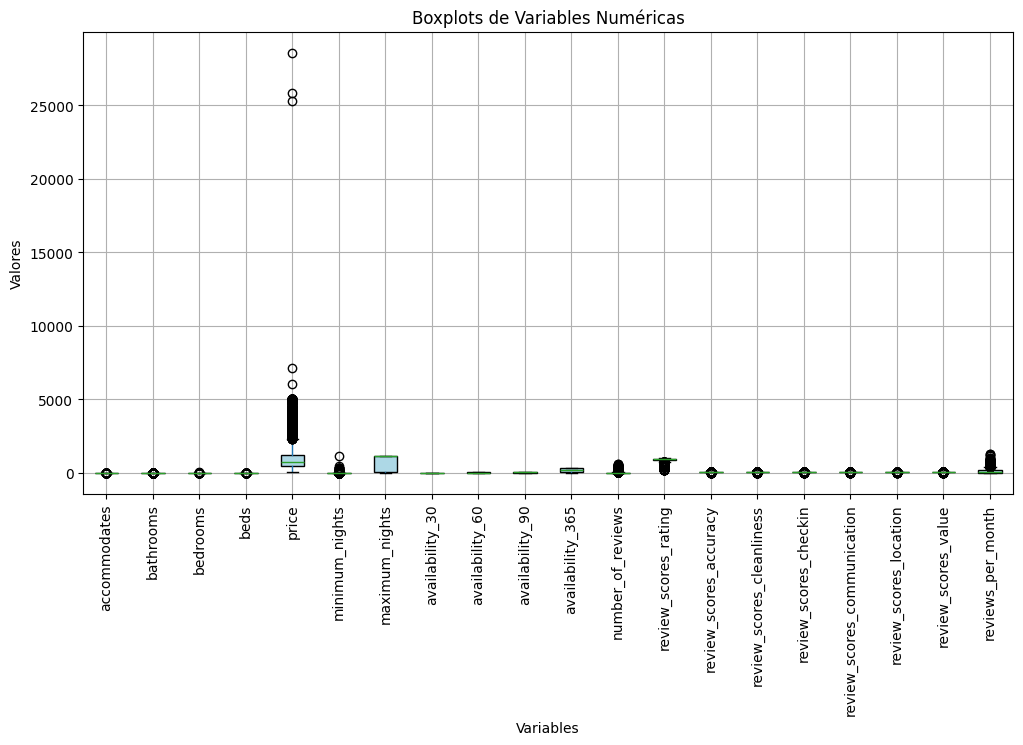

In [4]:
# Filtrar solo variables numéricas
df_numericas = df.select_dtypes(include=[np.number]).drop(columns=['apartment_id', 'host_id'],errors = 'ignore')

# Calcular estadísticas básicas
estadisticas = df_numericas.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
estadisticas.columns = ['Media', 'Desviación estándar', 'Mínimo', 'Q1 (25%)', 'Mediana', 'Q3 (75%)', 'Máximo']

# Redondear a dos decimales
estadisticas = estadisticas.round(2)

# Mostrar estadísticas
print("\n Distribución Variables Numéricas:\n")
print(estadisticas.to_string())

# Crear boxplots de todas las variables numéricas
plt.figure(figsize=(12, 6))
df_numericas.boxplot(rot=90, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Boxplots de Variables Numéricas")
plt.xlabel("Variables")
plt.ylabel("Valores")
plt.grid(True)
plt.show()

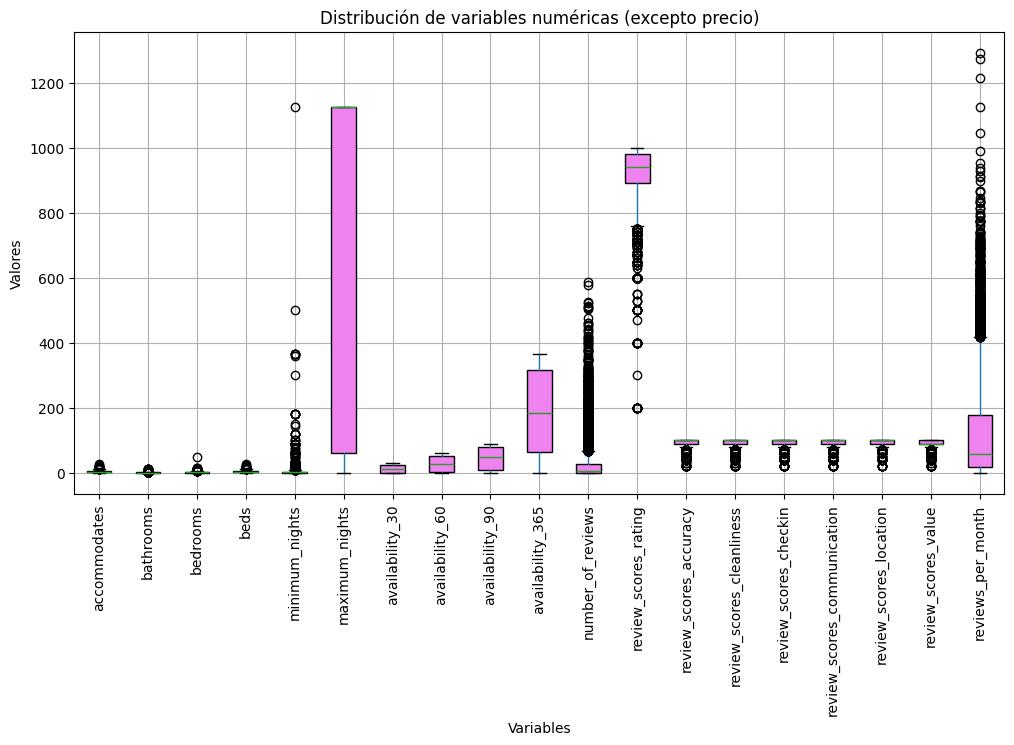

In [5]:
# nuevo gráfico para poder ver mejor las distribuciones

df_no_price = df_numericas.drop('price', axis=1)
plt.figure(figsize=(12, 6))
df_no_price.boxplot(rot=90, patch_artist=True, boxprops=dict(facecolor="violet"))
plt.title("Distribución de variables numéricas (excepto precio)")
plt.xlabel("Variables")
plt.ylabel("Valores")
plt.grid(True)
plt.show()

### Limpieza de duplicados

In [6]:
# se ordenan por fecha, se conserva el primer registro duplicado
df = (df.sort_values(by='insert_date')
    .drop_duplicates(subset='apartment_id', keep='first')
    .reset_index(drop=True)
)

df.duplicated(subset='apartment_id').sum()

np.int64(0)

### Verificación de nulos

In [7]:
df.isnull().sum()

apartment_id                      0
name                              0
host_id                           0
neighbourhood_name                0
neighbourhood_district            0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
amenities_list                    0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
first_review_date              6647
last_review_date               6681
review_scores_rating           2625
review_scores_accuracy         2634
review_scores_cleanliness      2628
review_scores_checkin          2639
review_scores_communication    2630
review_scores_location      

## Total de registros del dataframe a trabajar

In [8]:
registros_totales = len(df)

duplicados = df['apartment_id'].duplicated().sum()

print(f'Total de registros del dataset: {registros_totales}')
print(f'Total de duplicados exactos: {df.duplicated().sum()}')
print(f"El número de apartment_id duplicados es: {duplicados}")

Total de registros del dataset: 9650
Total de duplicados exactos: 0
El número de apartment_id duplicados es: 0


## EDA CX

In [9]:
# valores únicos en cada columna
df.apply(pd.Series.nunique)

apartment_id                   9650
name                           9615
host_id                        7268
neighbourhood_name              521
neighbourhood_district           62
room_type                         4
accommodates                     21
bathrooms                        14
bedrooms                         15
beds                             21
amenities_list                 9488
price                           415
minimum_nights                   49
maximum_nights                  147
has_availability                  2
availability_30                  31
availability_60                  61
availability_90                  91
availability_365                366
number_of_reviews               317
first_review_date               875
last_review_date                599
review_scores_rating             46
review_scores_accuracy            9
review_scores_cleanliness         9
review_scores_checkin             8
review_scores_communication       8
review_scores_location      

### Filtrado de df sin reviews

In [10]:
df_no_reviews = df[df["number_of_reviews"] == 0]
df_with_reviews = df[df["number_of_reviews"] > 0]

registros_no_reviews = len(df_no_reviews)
registros_with_reviews = len(df_with_reviews)

no_review_percentage = ((df["number_of_reviews"] == 0).sum() / df["number_of_reviews"].count() * 100).round()

print(f'Registros totales: {registros_totales}\nTotal de registros sin reviews: {registros_no_reviews}\nTotal de registros con reviews: {registros_with_reviews}\nPorcentaje de alojamientos sin reviews: {no_review_percentage}%')

Registros totales: 9650
Total de registros sin reviews: 2544
Total de registros con reviews: 7106
Porcentaje de alojamientos sin reviews: 26.0%


In [11]:
df_with_reviews.isnull().sum()

apartment_id                      0
name                              0
host_id                           0
neighbourhood_name                0
neighbourhood_district            0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
amenities_list                    0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
first_review_date              4117
last_review_date               4150
review_scores_rating            105
review_scores_accuracy          114
review_scores_cleanliness       108
review_scores_checkin           119
review_scores_communication     110
review_scores_location      

Dado que el filtrado por number_of_reviews deja más de 100 nulos para las variables que más nos interesarán en los análisis (accuracy, cleanlines, check-in, communication, location, value), se procede a filtrar por review_scores_rating, es decir, se conservarán para el análisis los registros que sí tengan calificación general (review_scores_rating).

### Filtrado de df sin rating

In [12]:
df_no_rating = df[pd.isna(df["review_scores_rating"])]
df_with_rating = df[df["review_scores_rating"].notna()]

registros_no_rating = len(df_no_rating)
registros_with_rating = len(df_with_rating)

no_rating_percentage = round((registros_no_rating / registros_totales) * 100, 2)

print(f'Registros totales: {registros_totales}\nTotal de registros sin rating: {registros_no_rating}\nTotal de registros con rating: {registros_with_rating}\nPorcentaje de alojamientos sin rating: {no_rating_percentage}%')

Registros totales: 9650
Total de registros sin rating: 2625
Total de registros con rating: 7025
Porcentaje de alojamientos sin rating: 27.2%


In [13]:
df_with_rating.isnull().sum()

apartment_id                      0
name                              0
host_id                           0
neighbourhood_name                0
neighbourhood_district            0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
amenities_list                    0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
first_review_date              4067
last_review_date               4098
review_scores_rating              0
review_scores_accuracy            9
review_scores_cleanliness         3
review_scores_checkin            14
review_scores_communication       5
review_scores_location      

In [14]:
items = ['review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
df_with_nulls = df_with_rating[df_with_rating[items].isna().any(axis=1)]
df_with_nulls.head()

,apartment_id,name,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,city,insert_date
278,7304217,Double room in penthouse with terrace,24516329,l'Antiga Esquerra de l'Eixample,Eixample,Private room,1,2.0,1.0,1,"TV,Cable TV,Internet,Wireless Internet,Air con...",390.0,14,1125,False,7,37,62,62,1,NaN,NaN,1000.0,NaN,NaN,NaN,100.0,100.0,100.0,True,5.0,barcelona,2017-04-08
335,16234816,"Beautiful Atico in Gracia, with a 70sqm Terrace",22118061,la Vila de Gr�cia,Gr�cia,Entire home/apt,3,1.0,1.0,3,"Internet,Wireless Internet,Air conditioning,Ki...",600.0,10,15,False,4,16,30,57,1,2017-02-01,2017-02-01,600.0,NaN,40.0,60.0,80.0,80.0,80.0,False,24.0,barcelona,2017-05-07
394,18965530,Casa,92341350,el Guinard�,Horta-Guinard�,Private room,1,1.0,1.0,1,"TV,Cable TV,Wireless Internet,Wheelchair acces...",250.0,1,3,False,30,56,86,361,1,NaN,NaN,600.0,60.0,60.0,60.0,80.0,NaN,NaN,False,10.0,barcelona,2017-06-05
616,16209983,"Bright, stylish, central, near the Sagrada Fam...",5878688,la Dreta de l'Eixample,Eixample,Entire home/apt,4,2.0,2.0,4,"TV,Wireless Internet,Air conditioning,Kitchen,...",1350.0,2,29,True,5,29,53,317,2,2017-02-01,2017-12-02,1000.0,100.0,100.0,100.0,100.0,NaN,NaN,False,22.0,barcelona,2017-10-07
622,7113910,Cozy room with private balcony,37210379,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,1.0,1.0,2,"Wireless Internet,Kitchen,Buzzer/wireless inte...",400.0,1,1125,True,0,0,0,0,1,2015-10-07,2015-10-07,800.0,NaN,NaN,NaN,100.0,80.0,100.0,False,4.0,barcelona,2017-10-07


#### Imputación de valores nulos en los items

In [ ]:
# se imputan los valores faltantes con la media y se verifica que los items no tengan nulos
df_with_rating[items] = df_with_rating[items].apply(lambda x: x.fillna(x.median()))

df_with_rating.isnull().sum()

C:\Users\Evelyn\AppData\Local\Temp\ipykernel_20216\2940727709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_rating[items] = df_with_rating[items].apply(lambda x: x.fillna(x.median()))


apartment_id                      0
name                              0
host_id                           0
neighbourhood_name                0
neighbourhood_district            0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
amenities_list                    0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
first_review_date              4067
last_review_date               4098
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location      

### Rating

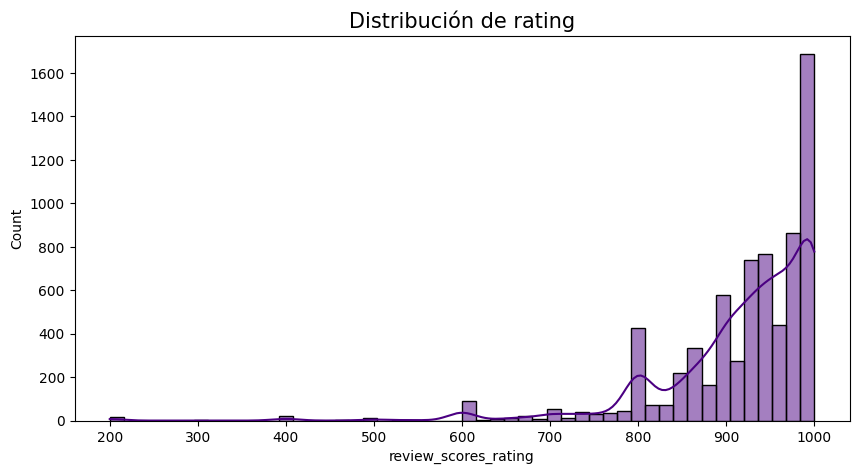

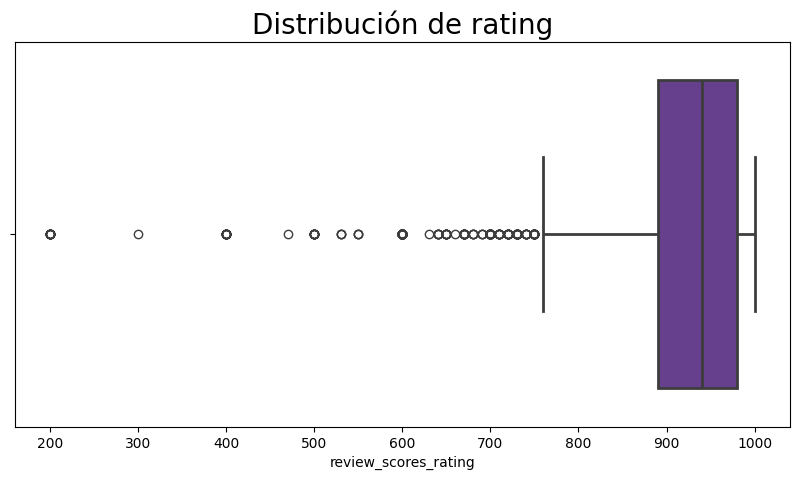

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(df_with_rating['review_scores_rating'], bins=50, kde=True, color='indigo')
plt.title('Distribución de rating', fontsize=15)


fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_rating', color='rebeccapurple', linewidth=2)
plt.title('Distribución de rating', fontsize=20)

plt.show();

### Accuracy

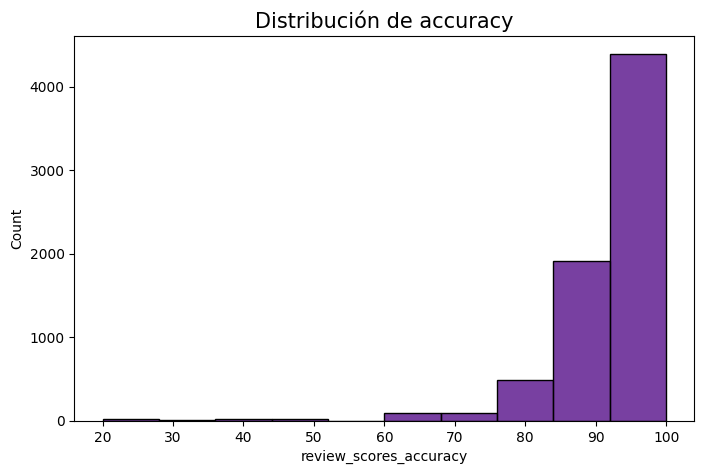

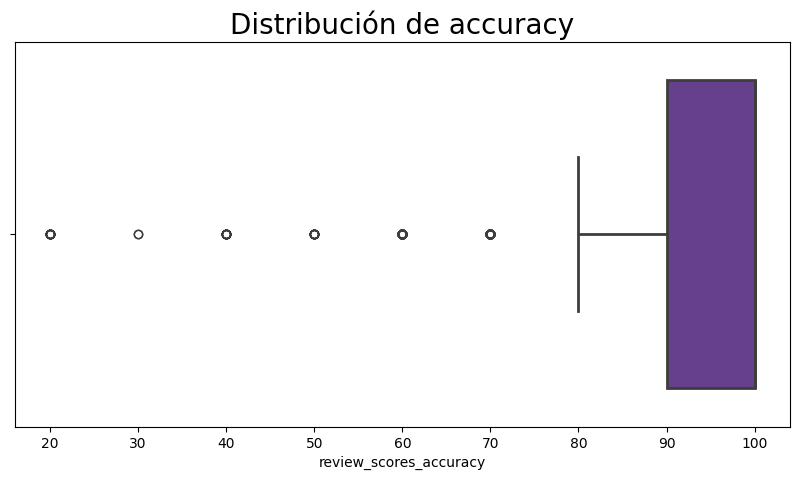

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(df_with_rating['review_scores_accuracy'], bins=10, color='indigo')
plt.title('Distribución de accuracy', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_accuracy', color='rebeccapurple', linewidth=2)
plt.title('Distribución de accuracy', fontsize=20)

plt.show();

### Cleanliness

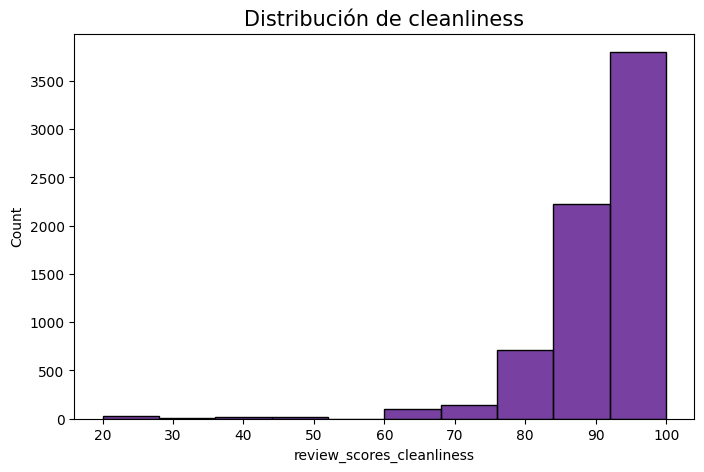

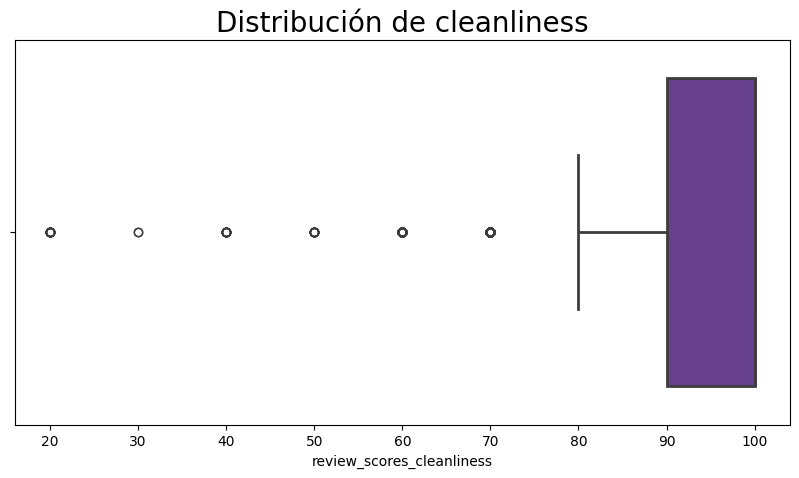

In [18]:
plt.figure(figsize=(8, 5))
sns.histplot(df_with_rating['review_scores_cleanliness'], bins=10, color='indigo')
plt.title('Distribución de cleanliness', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_cleanliness', color='rebeccapurple', linewidth=2)
plt.title('Distribución de cleanliness', fontsize=20)

plt.show();

### Checkin

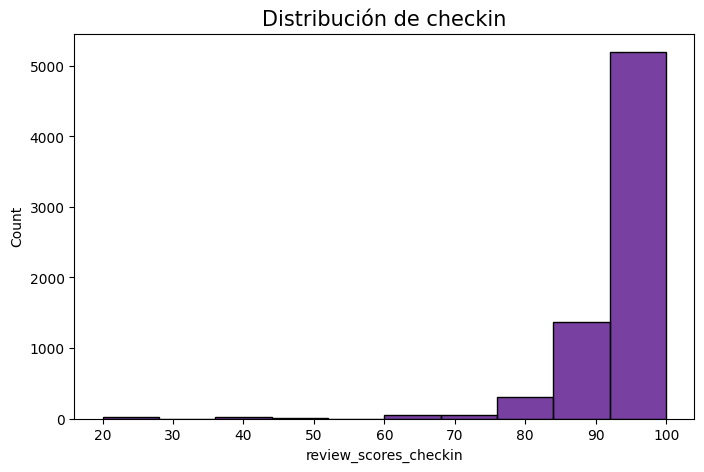

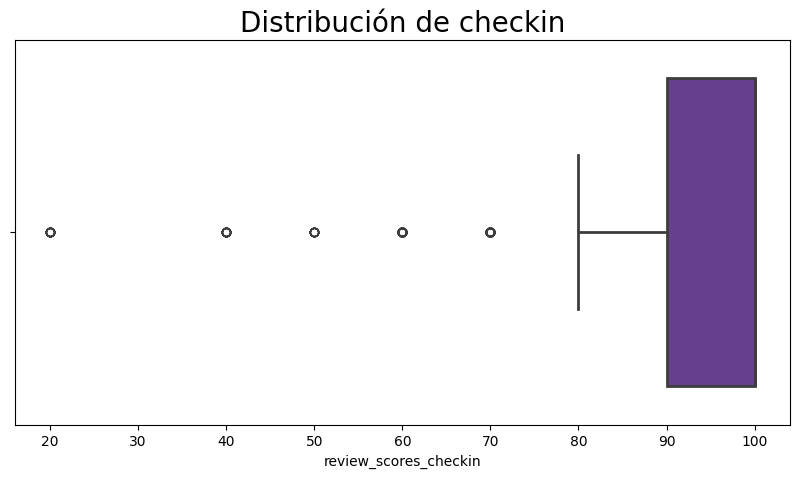

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(df_with_rating['review_scores_checkin'], bins=10, color='indigo')
plt.title('Distribución de checkin', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_checkin', color='rebeccapurple', linewidth=2)
plt.title('Distribución de checkin', fontsize=20)

plt.show();

### Communication

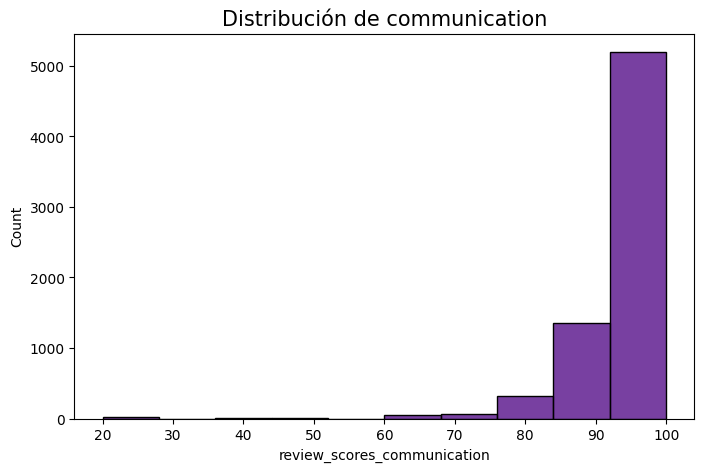

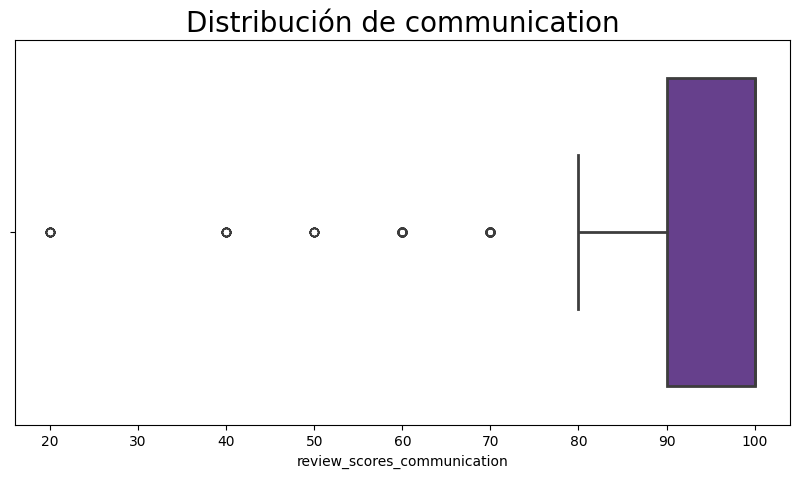

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(df_with_rating['review_scores_communication'], bins=10, color='indigo')
plt.title('Distribución de communication', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_communication', color='rebeccapurple', linewidth=2)
plt.title('Distribución de communication', fontsize=20)

plt.show();

### Location

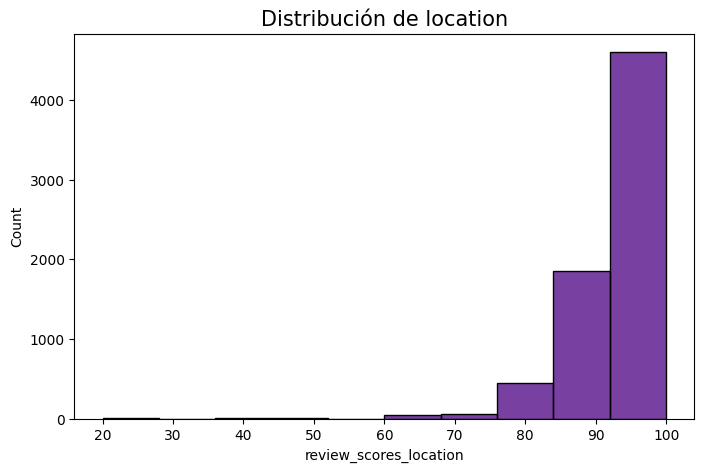

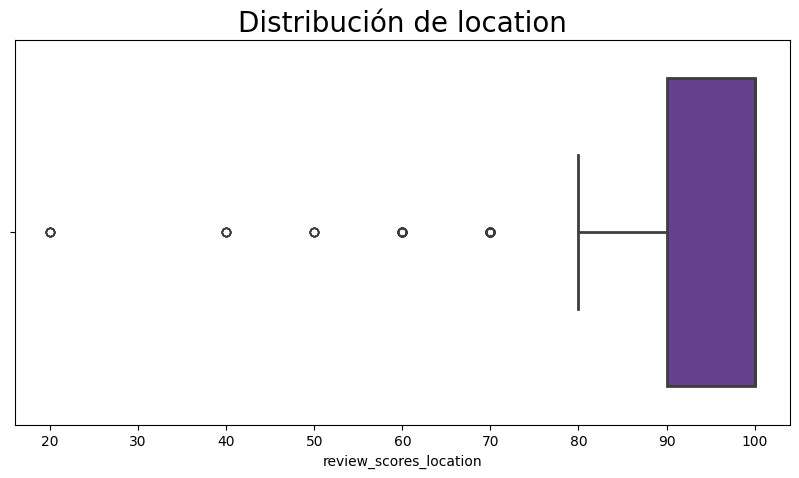

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(df_with_rating['review_scores_location'], bins=10, color='indigo')
plt.title('Distribución de location', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_location', color='rebeccapurple', linewidth=2)
plt.title('Distribución de location', fontsize=20)

plt.show();

### Value

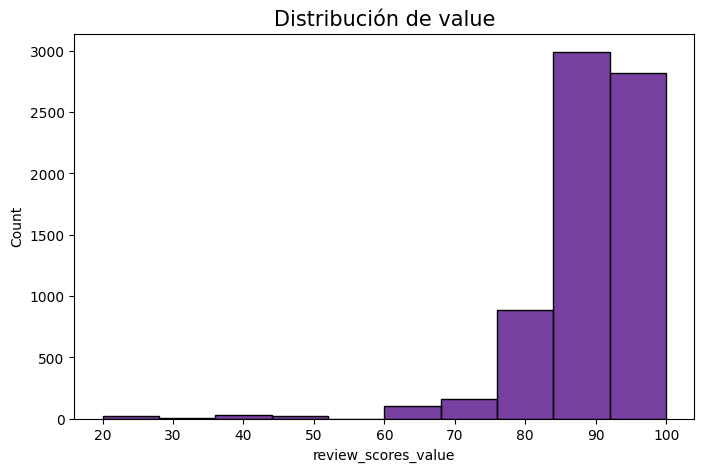

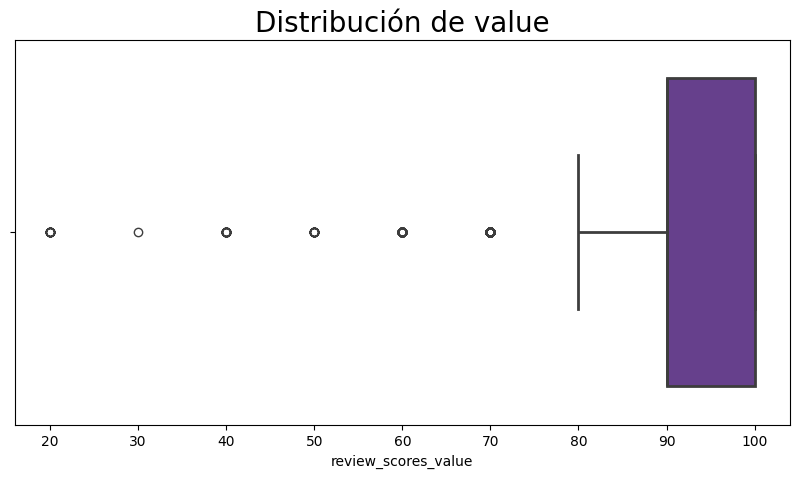

In [22]:
plt.figure(figsize=(8, 5))
sns.histplot(df_with_rating['review_scores_value'], bins=10, color='indigo')
plt.title('Distribución de value', fontsize=15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_with_rating, x='review_scores_value', color='rebeccapurple', linewidth=2)
plt.title('Distribución de value', fontsize=20)

plt.show();

### Relaciones entre variables

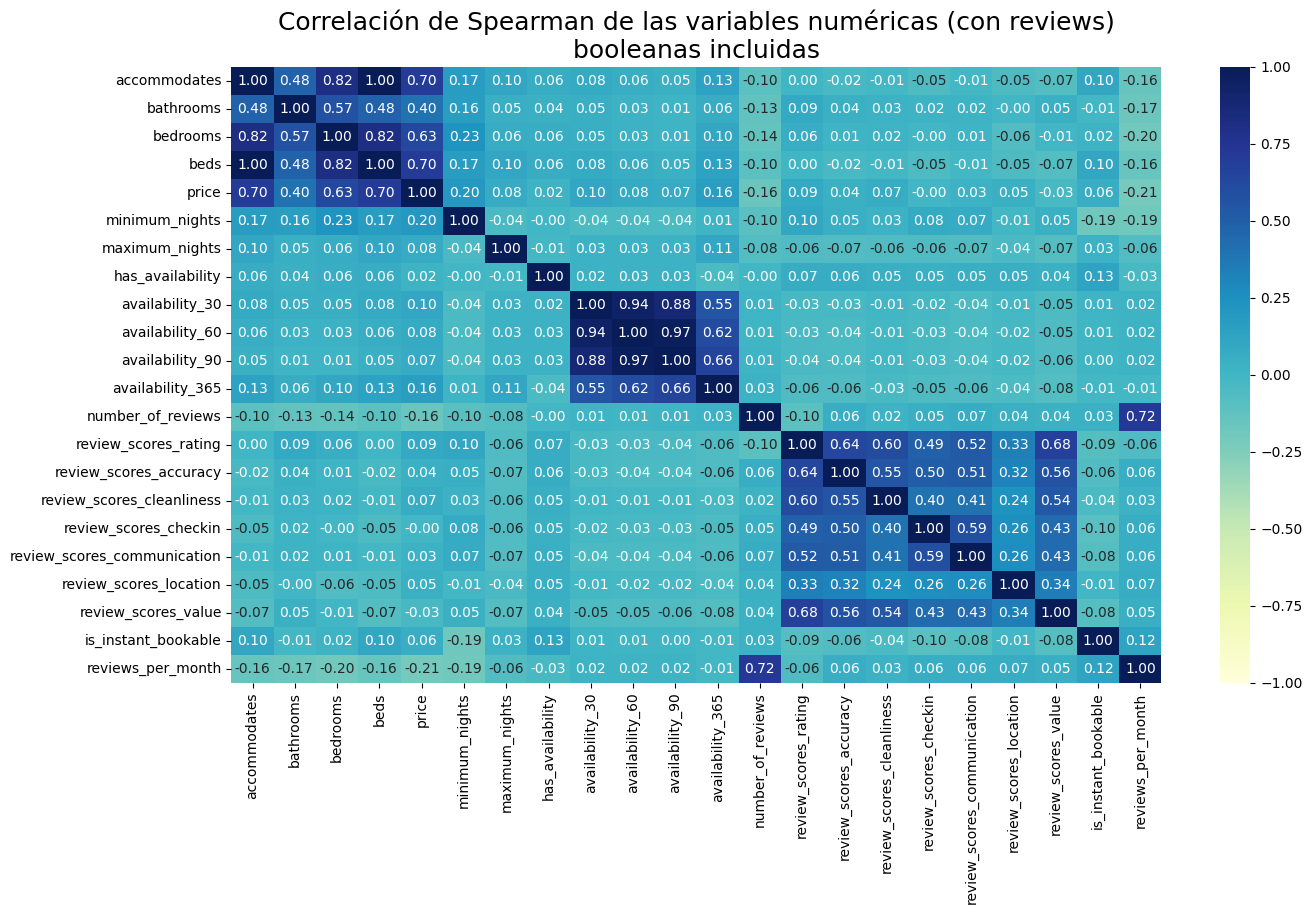

In [23]:
# correlación de Spearman con booleanas

non_num_variables = ['apartment_id', 'host_id']
df_numeric = df_with_rating.drop(columns=non_num_variables)

plt.figure(figsize=(15, 8))
sns.heatmap(df_numeric.corr(method='spearman', numeric_only=True), vmin= -1, vmax=1, annot=True, cmap='YlGnBu', fmt=".2f")

plt.title('Correlación de Spearman de las variables numéricas (con reviews)\nbooleanas incluidas', fontsize=18)
plt.show();

En cuanto a las variables relativas a las reviews, hay correlaciones entre cada uno de los 6 items evaluados por los usuarios con respecto a la calificación general otorgada. La correlación más débil entre calificación general y un ítem concreto es la de la ubicación, seguida del check in. Esto puede deberse a que ubicación del alojamiento es una característica que el cliente ya conoce y acepta más fácilmente que los demás aspectos que pueden variar más y ser más objetivos y diferir de sus expectativas.

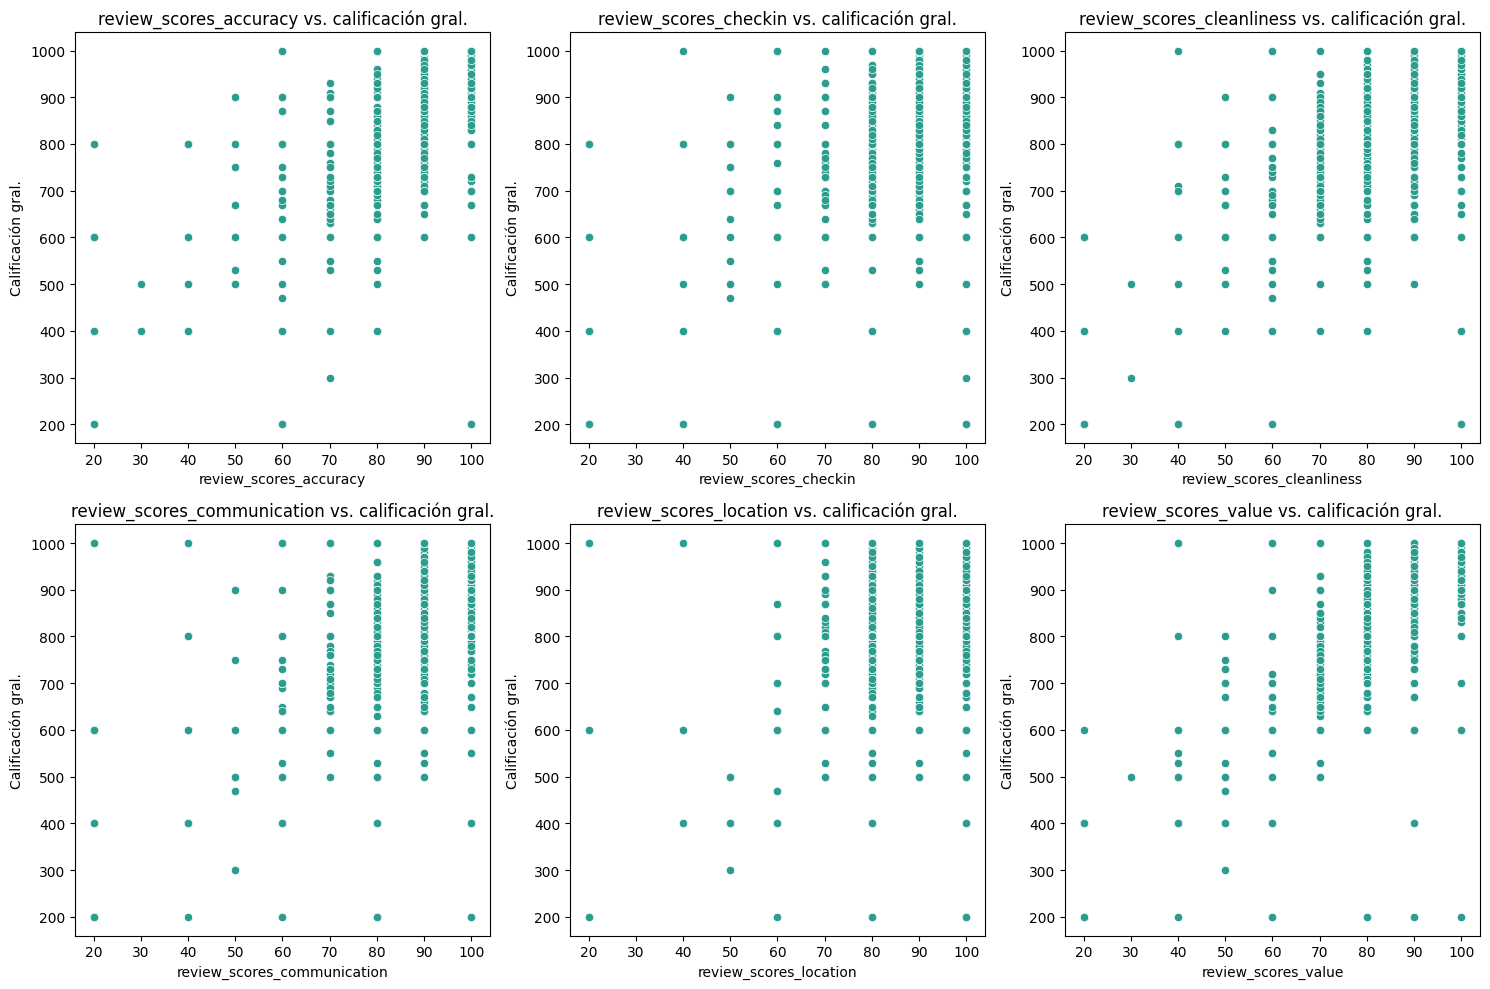

In [24]:
items = ['review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

selected_columns = items + ['review_scores_rating']
df_selected = df_with_rating[selected_columns]

# scatterplots
plt.figure(figsize=(15, 10))

for i, category in enumerate(items, 1):
    plt.subplot(2, 3, i)  # 2 filas, 3 columnas
    sns.scatterplot(x=df_selected[category], y=df_selected['review_scores_rating'], color='#2A9D8F')
    
    plt.title(f"{category} vs. calificación gral.")
    plt.xlabel(category)
    plt.ylabel("Calificación gral.")

plt.tight_layout()
plt.show()

## KPIs de CX

### 3. Índice de satisfacción general
El índice de satisfacción general del cliente (CSAT) es el porcentaje de clientes satisfechos y se calcula sumando las puntuaciones otorgadas, diviendo entre el número total de respuestas y multiplicando por 100.

In [25]:
# es el índice que se nos pidió, pero nuestra escala es 0-1000, habrá que adaptarla para sacar un porcentaje coherente

csat_gral = df["review_scores_rating"].sum()/df.shape[0]
print(f'Índice de satisfacción general: {csat_gral.round()}')

Índice de satisfacción general: 669.0


In [26]:
# Este es el otro CSAT, solo las mejores puntuaciones

respuestas_top = df[(df['review_scores_rating'] >= 800) & (df['review_scores_rating'] <= 1000)]['review_scores_rating'].count()
respuestas_totales = df['review_scores_rating'].count()

csat = (respuestas_top / respuestas_totales) * 100

print(f"Índice de satisfacción CSAT: {csat:.2f}%")

Índice de satisfacción CSAT: 94.31%


### 4. Item con más satisfacción media

In [27]:
avg_accuracy = df["review_scores_accuracy"].mean().round(2)
avg_cleanliness = df["review_scores_cleanliness"].mean().round(2)
avg_chekin = df["review_scores_checkin"].mean().round(2)
avg_communication = df["review_scores_communication"].mean().round(2)
avg_location = df["review_scores_location"].mean().round(2)
avg_value = df["review_scores_value"].mean().round(2)

diccionario = {'avg_accuracy': avg_accuracy, 'avg_cleanliness': avg_cleanliness, 'avg_checkin': avg_chekin, 'avg_communication': avg_communication, 'avg_location': avg_location, 'avg_location': avg_value}

print(f'Item con más satisfacción media: {max(diccionario, key=diccionario.get)}')
print(f'Item con menor satisfacción media: {min(diccionario, key=diccionario.get)}')
print(f'Valores medios:\n    Accuracy: {avg_accuracy}\n    Cleanliness: {avg_cleanliness}\n    Checkin: {avg_chekin}\n    Communication: {avg_communication}\n    Location: {avg_location}\n    Value: {avg_value}')

Item con más satisfacción media: avg_checkin
Item con menor satisfacción media: avg_location
Valores medios:
    Accuracy: 94.49
    Cleanliness: 93.11
    Checkin: 96.22
    Communication: 96.2
    Location: 95.42
    Value: 91.37


## Desafío 1 - Preguntas de negocio: en Power BI

### Calificación media de los alojamientos

In [28]:
avg_rating = df_with_rating['review_scores_rating'].mean().round(2)
print(f'Calificación media de los alojamientos: {avg_rating}/1000')

Calificación media de los alojamientos: 919.02/1000


### Porcentaje de alojamientos con calificación sobre 80 por ciudad

In [29]:
# ciudad_agrupada = df_with_rating.groupby("city")["review_scores_rating"]
# porcentaje_mayor_800 = (ciudad_agrupada.apply(lambda x: (x > 800).mean()) * 100).round().reset_index()

# porcentaje_mayor_800


# Desafío 2

## Paleta de colores

In [30]:
paleta = [
    "#1B3C59",  # Azul profundo
    "#3A5A40",  # Verde bosque
    "#8BAAAD",  # Azul grisáceo
    "#D9D9D9",  # Gris claro
    "#E8F1F2",  # Azul hielo
    "#A67C52",  # Marrón tostado
    "#F4A261",  # Naranja suave
    "#264653",  # Azul petróleo
    "#A8DADC",  # Turquesa claro
    "#457B9D",  # Azul medio
    "#E63946",  # Rojo coral
    "#F4E285",  # Amarillo pastel
    "#2A9D8F",  # Verde esmeralda
    "#6D597A",  # Morado apagado
    "#B5838D"   # Rosa viejo
]

## Preguntas de negocio
¿Qué aspectos (precisión de detalles, higiene, check-in o comunicación) presentan diferencias más grandes entre los alojamientos mejor y peor valorados en la evaluación general?

## Método 1 - Comparación entre valor máximo y mínimo

### Promedio del máximo rating 

In [31]:
max_rating = df_with_rating[df_with_rating['review_scores_rating'] == df_with_rating['review_scores_rating'].max()]

print("Registro con el máximo review_scores_rating:")
max_rating

Registro con el máximo review_scores_rating:


,apartment_id,name,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,city,insert_date
3,16272738,Comfortable double bedroom Parc G�ell,13952311,el Baix Guinard�,Horta-Guinard�,Private room,2,2.0,1.0,2,"TV,Wireless Internet,Kitchen,Smoking allowed,B...",760.0,2,1125,False,27,55,85,360,1,2017-02-01,2017-02-01,1000.0,100.0,100.0,100.0,80.0,80.0,80.0,True,10.0,barcelona,2017-01-04
19,15491387,Lovely Double room in beautiful apartment,36666424,el Camp de l'Arpa del Clot,Sant Mart�,Private room,2,1.0,1.0,2,"TV,Wireless Internet,Air conditioning,Kitchen,...",300.0,1,1125,False,21,46,70,95,3,2016-01-11,NaN,1000.0,100.0,100.0,100.0,100.0,100.0,100.0,False,134.0,barcelona,2017-01-04
29,13214194,HABITACI�N DOBLE AMPLIA Y SOLEADA CON BALC�N,74091650,la Dreta de l'Eixample,Eixample,Private room,2,1.0,1.0,2,"TV,Wireless Internet,Kitchen,Smoking allowed,P...",320.0,10,40,False,29,59,89,364,2,NaN,NaN,1000.0,100.0,100.0,100.0,100.0,100.0,100.0,False,41.0,barcelona,2017-01-04
37,3847290,Banyoles,19681580,el Barri G�tic,Ciutat Vella,Private room,2,1.0,1.0,2,"TV,Wireless Internet,Air conditioning,Buzzer/w...",890.0,1,1125,False,30,57,87,357,1,2016-09-08,2016-09-08,1000.0,100.0,100.0,100.0,100.0,100.0,100.0,False,2.0,barcelona,2017-01-04
38,4690195,Two-bedroom Beach Apartment (880),24001256,Diagonal Mar i el Front Mar�tim del Poblenou,Sant Mart�,Entire home/apt,4,1.0,2.0,4,"TV,Wireless Internet,Air conditioning,Pool,Kit...",1680.0,3,1125,False,30,60,90,362,1,NaN,NaN,1000.0,100.0,100.0,100.0,100.0,100.0,100.0,False,7.0,barcelona,2017-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9609,26207763,Casa Flor.....somewhere different,196976392,L'Escala,Desconocido,Entire home/apt,2,1.0,1.0,2,"Host greets you, Cooking basics, Garden or bac...",1100.0,3,1125,True,0,0,16,265,39,2018-01-07,2020-07-09,1000.0,100.0,100.0,100.0,100.0,100.0,100.0,False,12.0,girona,2021-02-27
9615,18499980,Apartamento en Port D'Aro,128380878,Castell-Platja d'Aro,Desconocido,Entire home/apt,6,2.0,3.0,6,"Washer, Wifi, Essentials, Pool, Bathtub, Heati...",1140.0,6,1125,True,0,0,0,0,4,NaN,NaN,1000.0,100.0,100.0,100.0,100.0,100.0,100.0,True,9.0,girona,2021-02-27
9616,18544317,GOOD SPOT EMPURIABRAVA,60510464,Castell� d'Emp�ries,Desconocido,Entire home/apt,4,1.0,1.0,4,"Smoke alarm, Bed linens, Stove, Elevator, Sing...",700.0,3,62,True,0,0,0,0,5,2017-09-08,2019-07-10,1000.0,100.0,100.0,100.0,100.0,100.0,100.0,False,12.0,girona,2021-02-27
9623,19236052,Apartment with garden & pool - 800 m Pals beac...,133933726,Pals,Desconocido,Entire home/apt,7,2.0,3.0,7,"Cooking basics, Garden or backyard, Bathtub, H...",1160.0,1,1125,True,0,0,26,224,1,NaN,NaN,1000.0,80.0,100.0,80.0,80.0,80.0,80.0,True,3.0,girona,2021-02-27


In [32]:
min_rating = df_with_rating[df_with_rating['review_scores_rating'] == df_with_rating['review_scores_rating'].min()]

print("\nRegistro con el mínimo review_scores_rating:")
min_rating


Registro con el mínimo review_scores_rating:


,apartment_id,name,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,city,insert_date
275,7262469,Habitaci�n doble en Poble Sec,38021841,Sant Antoni,Eixample,Private room,2,1.0,1.0,2,"TV,Cable TV,Internet,Wireless Internet,Air con...",380.0,1,1125,False,0,0,0,0,1,2015-01-09,2015-01-09,200.0,20.0,20.0,40.0,60.0,100.0,20.0,False,5.0,barcelona,2017-04-08
1092,22995415,Barbieri City Center,54310958,Justicia,Centro,Entire home/apt,4,1.0,1.0,4,"TV,Wifi,Kitchen,Elevator,Heating,Family/kid fr...",970.0,2,1125,True,16,42,66,148,1,NaN,NaN,200.0,20.0,20.0,40.0,20.0,100.0,20.0,True,10.0,madrid,2018-04-12
1361,21418557,Roomspace Sandoval- Glorieta de Bilbao 2,31772865,Trafalgar,Chamber�,Entire home/apt,2,1.0,1.0,2,Sin información,1150.0,3,1125,True,30,60,90,365,1,NaN,NaN,200.0,20.0,20.0,20.0,20.0,20.0,20.0,False,22.0,madrid,2018-05-14
1893,27603327,Apartment In Lloret De Mar Fenals,23730135,Lloret de Mar,Desconocido,Entire home/apt,4,1.0,1.0,4,"TV,Cable TV,Wifi,Pool,Kitchen,Smoking allowed,...",790.0,4,1125,True,17,19,29,29,1,2018-12-08,2018-12-08,200.0,60.0,20.0,60.0,60.0,80.0,20.0,True,10.0,girona,2018-08-30
2153,19247709,CRISSON,134761428,L'Escala,Desconocido,Entire home/apt,6,2.0,3.0,6,"TV,Internet,Wifi,Kitchen,Smoking allowed,Pets ...",890.0,3,1125,True,28,58,88,92,1,2018-01-04,2018-01-04,200.0,20.0,20.0,100.0,100.0,100.0,20.0,True,16.0,girona,2018-09-28
2305,26125080,Finca Ses Colonies,196373641,Ses Salines,Desconocido,Private room,12,7.0,6.0,12,"TV,Wifi,Air conditioning,Pool,Kitchen,Free par...",4500.0,2,30,True,29,59,89,364,1,2018-05-08,2018-05-08,200.0,20.0,40.0,60.0,20.0,80.0,60.0,True,41.0,mallorca,2018-10-17
2360,17649686,Spacious and sunny apartment for 5/6 persons.,98454076,Llan��,Desconocido,Entire home/apt,6,1.0,3.0,6,"TV,Cable TV,Kitchen,Smoking allowed,Pets allow...",710.0,1,1125,True,7,7,7,7,1,NaN,NaN,200.0,100.0,20.0,100.0,100.0,100.0,90.0,True,7.0,girona,2018-10-20
2603,3073348,"APARTAMENTOS AQUARIUM. 25 M2 TERRAZA, BARBACOA",14040896,Roses,Desconocido,Entire home/apt,4,1.0,1.0,4,"TV,Kitchen,Smoking allowed,Pets allowed,Free s...",520.0,3,30,True,26,48,78,325,1,NaN,NaN,200.0,100.0,100.0,20.0,80.0,100.0,40.0,False,2.0,girona,2018-11-26
4631,18536423,La Ginesta (LES150),113497406,L'Escala,Desconocido,Entire home/apt,5,1.0,2.0,5,"TV,Pool,Kitchen,Smoking allowed,Family/kid fri...",350.0,1,28,True,0,6,35,310,1,2018-11-08,2018-11-08,200.0,100.0,100.0,100.0,100.0,100.0,80.0,True,8.0,girona,2019-07-29
6028,27824712,"Danna, Friendly Rentals",102947901,SANT FRANCESC,CIUTAT VELLA,Entire home/apt,6,2.0,3.0,6,"TV,Wifi,Air conditioning,Kitchen,Elevator,Wash...",500.0,1,27,True,27,52,79,352,1,2019-04-07,2019-04-07,200.0,20.0,60.0,80.0,80.0,20.0,20.0,True,16.0,valencia,2019-12-31


In [33]:
max_value = df_with_rating['review_scores_rating'].max()
min_value = df_with_rating['review_scores_rating'].min()

print(f'Valor máximo de review_scores_rating: {max_value}')
print(f'Valor mínimo de review_scores_rating: {min_value}')

Valor máximo de review_scores_rating: 1000.0
Valor mínimo de review_scores_rating: 200.0


In [34]:
# Obtener los registros donde review_scores_rating es igual al máximo valor
max_reviews = df_with_rating[df_with_rating['review_scores_rating'] == max_value]

# Seleccionar las columnas numéricas a promediar
columnas_a_promediar = [
    'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value', 'reviews_per_month'
]

# Calcular el promedio de estas columnas en los registros con el máximo valor
promedio_max_reviews = max_reviews[columnas_a_promediar].mean().round(2)

print("Promedio de las columnas para los registros con el máximo review_scores_rating:")
print(promedio_max_reviews)


Promedio de las columnas para los registros con el máximo review_scores_rating:
number_of_reviews                 5.02
review_scores_rating           1000.00
review_scores_accuracy           98.54
review_scores_cleanliness        97.69
review_scores_checkin            98.64
review_scores_communication      98.88
review_scores_location           97.51
review_scores_value              96.85
reviews_per_month                44.02
dtype: float64


### Promedio de los registros con el mínimo rating 

In [35]:
# Obtener los registros donde review_scores_rating es igual al máximo valor
min_reviews = df_with_rating[df_with_rating['review_scores_rating'] == min_value]

# Seleccionar las columnas numéricas a promediar
columnas_a_promediar = [
    'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value', 'reviews_per_month'
]

# Calcular el promedio de estas columnas en los registros con el máximo valor
promedio_min_reviews = min_reviews[columnas_a_promediar].mean()

# Mostrar resultados
print("Promedio de las columnas para los registros con el máximo review_scores_rating:")
print(promedio_min_reviews)

Promedio de las columnas para los registros con el máximo review_scores_rating:
number_of_reviews                1.000000
review_scores_rating           200.000000
review_scores_accuracy          38.823529
review_scores_cleanliness       32.941176
review_scores_checkin           56.470588
review_scores_communication     54.117647
review_scores_location          72.941176
review_scores_value             35.882353
reviews_per_month               11.647059
dtype: float64


### Comparativo 

In [36]:
total_max_reviews = max_reviews.shape[0]
total_min_reviews = min_reviews.shape[0]

print(f'N del df max_reviews: {total_max_reviews}\nN del df min_reviews: {total_min_reviews}')

N del df max_reviews: 1443
N del df min_reviews: 17


In [37]:
# Obtener el valor mínimo de review_scores_rating
min_value = df_with_rating['review_scores_rating'].min()

# Filtrar los registros con el valor máximo y mínimo
max_reviews = df_with_rating[df_with_rating['review_scores_rating'] == max_value]
min_reviews = df_with_rating[df_with_rating['review_scores_rating'] == min_value]

# Seleccionar las columnas numéricas a comparar
columnas_a_comparar = [
    'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value', 'reviews_per_month'
]

# Calcular el promedio de estas columnas para los registros con el valor máximo
promedio_max_reviews = max_reviews[columnas_a_comparar].mean()

# Calcular el promedio de estas columnas para los registros con el valor mínimo
promedio_min_reviews = min_reviews[columnas_a_comparar].mean()

# Calcular la diferencia (max - min)
diferencia = promedio_max_reviews - promedio_min_reviews

# Crear un DataFrame con la comparación
comparacion = pd.DataFrame({
    'Promedio Máximo Review': promedio_max_reviews,
    'Promedio Mínimo Review': promedio_min_reviews,
    'Diferencia (Max - Min)': diferencia
})

# Mostrar resultados
print("Comparación entre los registros con máximo y mínimo review_scores_rating:")
print(comparacion)

Comparación entre los registros con máximo y mínimo review_scores_rating:
                             Promedio Máximo Review  Promedio Mínimo Review  \
number_of_reviews                          5.018018                1.000000   
review_scores_rating                    1000.000000              200.000000   
review_scores_accuracy                    98.544699               38.823529   
review_scores_cleanliness                 97.692308               32.941176   
review_scores_checkin                     98.641719               56.470588   
review_scores_communication               98.877339               54.117647   
review_scores_location                    97.512128               72.941176   
review_scores_value                       96.853777               35.882353   
reviews_per_month                         44.020790               11.647059   

                             Diferencia (Max - Min)  
number_of_reviews                          4.018018  
review_scores_rating       

### Diferencia entre promedio máximo y mínimo

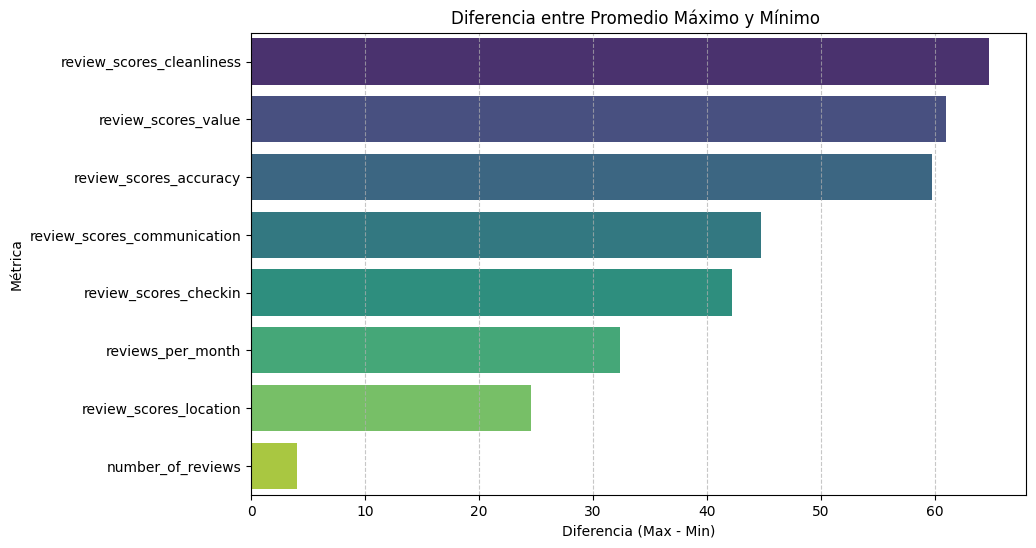

In [38]:
# Eliminar 'review_scores_rating' de las columnas a comparar
columnas_a_comparar_sin_rating = [col for col in columnas_a_comparar if col != 'review_scores_rating']

# Recalcular los promedios sin 'review_scores_rating'
promedio_max_reviews_sin_rating = max_reviews[columnas_a_comparar_sin_rating].mean()
promedio_min_reviews_sin_rating = min_reviews[columnas_a_comparar_sin_rating].mean()

# Calcular la diferencia (max - min) sin 'review_scores_rating'
diferencia_sin_rating = promedio_max_reviews_sin_rating - promedio_min_reviews_sin_rating

# Crear un DataFrame con la diferencia sin 'review_scores_rating'
comparacion_sin_rating = pd.DataFrame({
    'Diferencia (Max - Min)': diferencia_sin_rating
})

# Ordenar las diferencias de mayor a menor
diferencia_ordenada_sin_rating = comparacion_sin_rating['Diferencia (Max - Min)'].sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=diferencia_ordenada_sin_rating.values, y=diferencia_ordenada_sin_rating.index, hue=diferencia_ordenada_sin_rating.index, palette='viridis', legend=False)

plt.xlabel('Diferencia (Max - Min)')
plt.ylabel('Métrica')
plt.title('Diferencia entre Promedio Máximo y Mínimo ')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

## Método 2 - Comparación por segmentos (cuartiles inferior y superior)

### División del df en cuartiles: mejores y peores evaluados
Se crean dos nuevos dataframes para realizar las comparaciones: uno con los alojamientos mejor valorados, tomando el cuartil superior de la variable review_scores_rating, y el otro con los peor valorados, tomando el cuartil inferior.

In [39]:
# Cálculo de cuartiles para 'review_scores_rating'
Q1 = df_with_rating['review_scores_rating'].quantile(0.25)
Q3 = df_with_rating['review_scores_rating'].quantile(0.75)

# Los "peores" serán los valores <= Q1 y los "mejores" los valores >= Q3
peores = df_with_rating[df_with_rating['review_scores_rating'] <= Q1]
mejores = df_with_rating[df_with_rating['review_scores_rating'] >= Q3]

print(f'Q1 (25%): {Q1}')
print(f'Q3 (75%): {Q3}')
print(f'Número de peores (según cuartiles): {len(peores)}')
print(f'Número de mejores (según cuartiles): {len(mejores)}')

Q1 (25%): 890.0
Q3 (75%): 980.0
Número de peores (según cuartiles): 1846
Número de mejores (según cuartiles): 2114


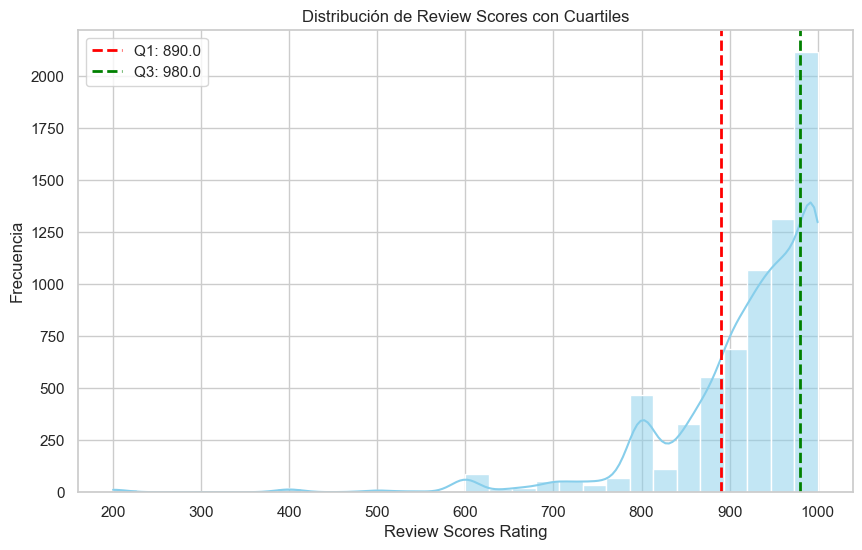

In [40]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_with_rating['review_scores_rating'], bins=30, kde=True, color='skyblue')

# líneas para Q1 y Q3
plt.axvline(Q1, color='red', linestyle='dashed', linewidth=2, label=f'Q1: {Q1}')
plt.axvline(Q3, color='green', linestyle='dashed', linewidth=2, label=f'Q3: {Q3}')

plt.xlabel('Review Scores Rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de Review Scores con Cuartiles')
plt.legend()

plt.show()

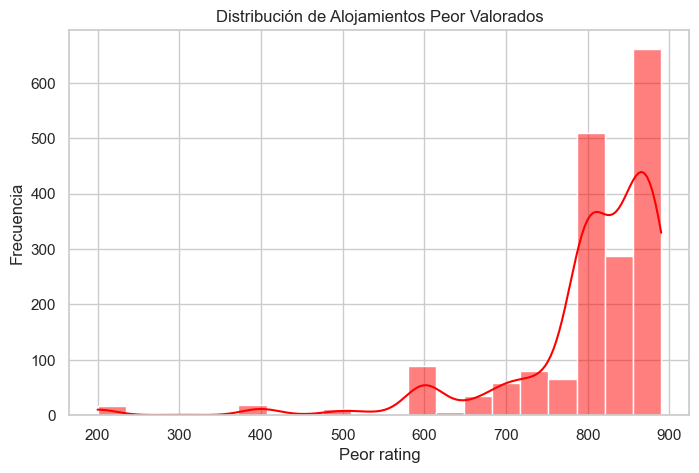

In [41]:
plt.figure(figsize=(8, 5))
sns.histplot(peores['review_scores_rating'], bins=20, kde=True, color='red')

plt.xlabel('Peor rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de Alojamientos Peor Valorados')
plt.show()

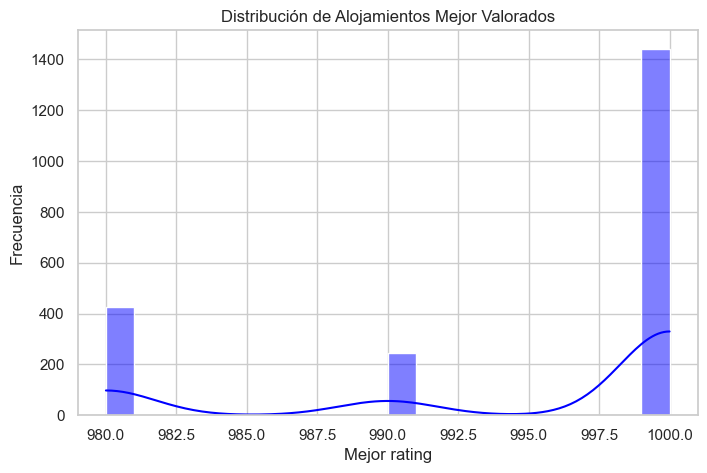

In [42]:
plt.figure(figsize=(8, 5))
sns.histplot(mejores['review_scores_rating'], bins=20, kde=True, color='blue')

plt.xlabel('Mejor rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de Alojamientos Mejor Valorados')
plt.show()

### Prueba Mann-Whitney U 

In [43]:
# mann whitney test 
stat, p_value = mannwhitneyu(peores['review_scores_accuracy'], mejores['review_scores_accuracy']) 
print('ACCURACY')
print('Statistics=%.2f, p=%.2f' % (stat, p_value)) 

# Level of significance 
alpha = 0.05

# conclusion 
if p_value < alpha: 
    print('Reject Null Hypothesis (Significant difference between two samples)') 
else: 
    print('Do not Reject Null Hypothesis (No significant difference between two samples)')

ACCURACY
Statistics=463011.50, p=0.00
Reject Null Hypothesis (Significant difference between two samples)


In [44]:
print(peores['review_scores_accuracy'].value_counts())
print(mejores['review_scores_accuracy'].value_counts())

review_scores_accuracy
90.0     917
80.0     398
100.0    312
70.0      88
60.0      79
20.0      21
40.0      16
50.0      13
30.0       2
Name: count, dtype: int64
review_scores_accuracy
100.0    1971
90.0       77
80.0       60
60.0        6
Name: count, dtype: int64


In [45]:
# Define the review categories
items = ['review_scores_accuracy', 'review_scores_cleanliness', 
                'review_scores_communication', 'review_scores_checkin', 
                'review_scores_location', 'review_scores_value']

# Calculate mean scores for best- and worst-rated accommodations
mejores_mean = mejores[items].mean()
peores_mean = peores[items].mean()

# Compute absolute mean differences
differences = (mejores_mean - peores_mean).abs()

# Perform Mann-Whitney U test for each category and store results
results = []
for item in items:
    # Drop NaN values before testing
    best_scores = mejores[item].dropna()
    worst_scores = peores[item].dropna()
    
    # Perform Mann-Whitney U Test
    stat, p_value = mannwhitneyu(worst_scores, best_scores)
    
    # Store results
    results.append((item, differences[item], stat, p_value))

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=['Review Item', 'Mean Difference', 'Mann-Whitney U', 'p-value'])

# Sort by highest mean difference
results_df = results_df.sort_values(by='Mean Difference', ascending=False)

# Display results
print(results_df)

# Filter statistically significant results (p < 0.05)
significant_results = results_df[results_df['p-value'] < 0.05]

print("\nStatistically Significant Differences (p < 0.05):")
print(significant_results)

                   Review Item  Mean Difference  Mann-Whitney U        p-value
5          review_scores_value        15.477280        382490.0   0.000000e+00
1    review_scores_cleanliness        13.832906        526436.0   0.000000e+00
0       review_scores_accuracy        13.234112        463011.5   0.000000e+00
2  review_scores_communication         9.468067        811879.0   0.000000e+00
3        review_scores_checkin         8.791311        883902.0  3.049471e-288
4       review_scores_location         6.251236       1172417.0  1.761177e-146

Statistically Significant Differences (p < 0.05):
                   Review Item  Mean Difference  Mann-Whitney U        p-value
5          review_scores_value        15.477280        382490.0   0.000000e+00
1    review_scores_cleanliness        13.832906        526436.0   0.000000e+00
0       review_scores_accuracy        13.234112        463011.5   0.000000e+00
2  review_scores_communication         9.468067        811879.0   0.000000e+00
3

### Comparación de los peor y mejor valorados (agrupados por cuartiles) en la evaluación general

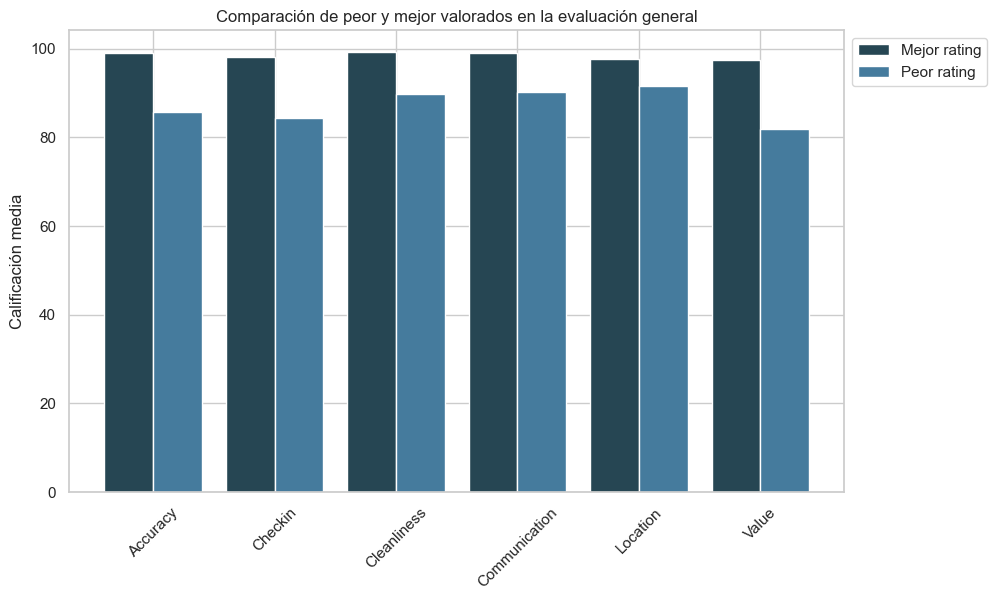

In [46]:
mejores_items = mejores[items].mean()
peores_items = peores[items].mean() 

x = np.arange(len(items)) 
width = 0.4  

plt.figure(figsize=(10, 6))

plt.bar(x - width/2, mejores_items, width, label="Mejor rating", color="#264653") 
plt.bar(x + width/2, peores_items, width, label="Peor rating", color="#457B9D")

etiquetas_items = ['Accuracy', 'Checkin', 'Cleanliness', 'Communication', 'Location', 'Value']
plt.xticks(x, etiquetas_items, rotation=45)
plt.ylabel('Calificación media')
plt.title("Comparación de peor y mejor valorados en la evaluación general")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.show()

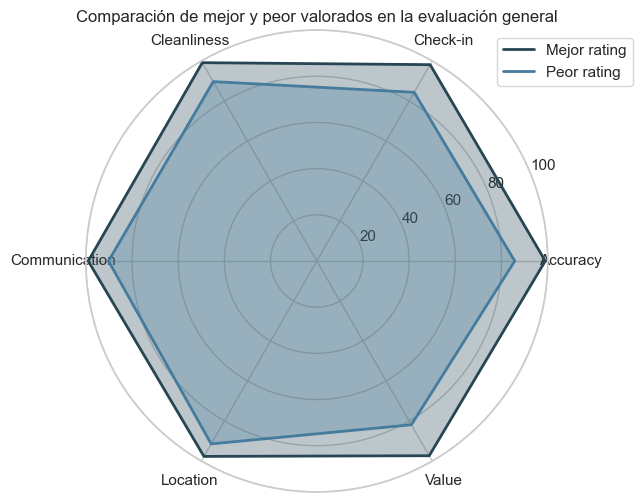

In [47]:
mejores_items = mejores[items].mean().values
peores_items = peores[items].mean().values

etiquetas_items = ['Accuracy', 'Check-in', 'Cleanliness', 'Communication', 'Location', 'Value']

# cantidad de variables
num_vars = len(items)

# ángulo de los ejes
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

mejores_items = np.concatenate((mejores_items, [mejores_items[0]]))
peores_items = np.concatenate((peores_items, [peores_items[0]]))
angles += angles[:1]  # cierra la forma

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# mejores
ax.plot(angles, mejores_items, color="#264653", linewidth=2, linestyle='solid', label="Mejor rating")
ax.fill(angles, mejores_items, color="#264653", alpha=0.3)

# peores
ax.plot(angles, peores_items, color="#457B9D", linewidth=2, linestyle='solid', label="Peor rating")
ax.fill(angles, peores_items, color="#457B9D", alpha=0.3)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(etiquetas_items)
plt.title("Comparación de mejor y peor valorados en la evaluación general")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


### Diferencia entre ambos grupos

In [48]:
diferencia_mejores_peores = (mejores[items].mean() - peores[items].mean()).round(2)

# se imprimen valores ordenados
diferencia_mejores_peores.sort_values(ascending=False)

review_scores_value            15.48
review_scores_cleanliness      13.83
review_scores_accuracy         13.23
review_scores_communication     9.47
review_scores_checkin           8.79
review_scores_location          6.25
dtype: float64

Los ítems con mayor diferencia entre los alojamientos mejor y peor evaluados son el Valor, la Limpieza y la Precisión de la descripción. Estas son, además, características que pueden ser muy subjetivas (a diferencia de la Ubicación, por ejemplo), por lo que los clientes pueden tener expectativas que el anfitrión quizá no sabe satisfacer. 

### Precio medio de los mejor y peor evaluados

In [49]:
avg_price_best = mejores['price'].mean().round(2)
avg_price_best

avg_price_worst = peores['price'].mean().round(2)
avg_price_worst

print(f'Precio medio de los alojamientos mejor evaluados: {avg_price_best}\nPrecio medio de los alojamientos peor evaluados: {avg_price_worst}')

Precio medio de los alojamientos mejor evaluados: 1055.83
Precio medio de los alojamientos peor evaluados: 874.05


## Propuestas de negocios

__Value__

-------- Evaluar las expectativas con respecto al precio

__Cleanliness__

--------- Estándares de limpieza
--------- ofrecer servicios de limpieza recomendados (compañías?)

__Accuracy__

Asesorar a los huéspedes para mejorar las descripciones y fotografías 

